## Deep Chem Library to predict reaction energies of molecular dataset

### Graph Convolutional Models

##### Import librearies 
This model is keras moodel and we need tensorflow and keras  

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import deepchem as dc
from rdkit import Chem
from deepchem.splits.splitters import ScaffoldSplitter,SpecifiedSplitter,RandomSplitter
from deepchem.models.graph_models import GraphConvModel
from deepchem.utils.evaluate import Evaluator
from keras.callbacks import ModelCheckpoint
import os

check version of deep chem 

In [2]:
print(dc.__version__)

2.4.0


In [3]:
from deepchem.models.losses import Loss

to have computational time

In [4]:
import time
start_time = time.time()

We use reddb final data from reddb databace

In [5]:
input_data="../final_data/train.csv"

In [6]:
df = pd.read_csv(input_data)

In [7]:
energy = df['reaction_energy'].to_numpy
ids = df['reactant_molecule_id'].to_numpy

<AxesSubplot:xlabel='reaction_energy', ylabel='reactant_molecule_id'>

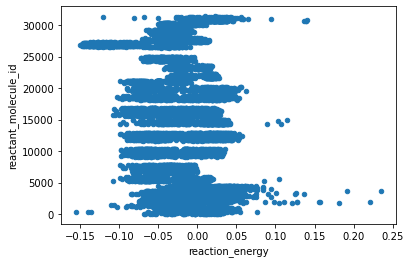

In [8]:
df.plot.scatter(x = 'reaction_energy',y = 'reactant_molecule_id')

In [9]:
# Run before every test for reproducibility
def seed_all():
    np.random.seed(123)
    tf.random.set_seed(123)

In [10]:
tasks=['reaction_energy']
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="reactant_smiles",featurizer=featurizer)
dataset=loader.featurize(input_data)


/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


In [11]:
dataset

<DiskDataset X.shape: (12707,), y.shape: (12707, 1), w.shape: (12707, 1), task_names: ['reaction_energy']>

In [12]:
seed_all()
splitter = dc.splits.RandomSplitter() #There is a "split" field in the dataset file where I  defined the training/valid/test set
#splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset,frac_train = 0.8,frac_valid = 0.2, frac_test = 0.0,seed = 0)


In [13]:
#splitter = dc.splits.ScaffoldSplitter()          #There is a "split" field in the dataset file where I  defined the training/valid/test set
#train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
model_dir = "./tf_ckpt_v2"

model = GraphConvModel(n_tasks=1, batch_size=100, mode='regression', dropout=0.25,model_dir= model_dir,random_seed=0)

In [14]:
train_dataset

<DiskDataset X.shape: (10165,), y.shape: (10165, 1), w.shape: (10165, 1), task_names: ['reaction_energy']>

In [15]:
valid_dataset

<DiskDataset X.shape: (2542,), y.shape: (2542, 1), w.shape: (2542, 1), task_names: ['reaction_energy']>

Normalizes data set to zero mean

In [16]:
transformers = dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset, move_mean=True)

In [17]:
train_dataset = transformers.transform(train_dataset)
valid_dataset= transformers.transform(valid_dataset)

In [18]:
train_dataset

<DiskDataset X.shape: (10165,), y.shape: (10165, 1), w.shape: (10165, 1), task_names: ['reaction_energy']>

In [19]:
model

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


GraphConvModel(batch_normalize=None, dense_layer_size=None, dropout=None,
               graph_conv_layers=None, mode='regression', n_tasks=1,
               number_atom_features=None)

In [20]:
# list of evaluation metrics = ["pearson_r2_score", "r2_score", "mean_squared_error","mean_absolute_error", "rms_score", "mae_score", "pearsonr",
#                            "concordance_index" ]
metric = dc.metrics.Metric(dc.metrics.r2_score, mode='regression')


Save our trained model to disk

In [21]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1))
manager = tf.train.CheckpointManager(ckpt, model_dir, max_to_keep=20)

Run and train model in 100 epoch

In [22]:
num_epochs = 100
losses_train = []
score_valid = []
for i in range(num_epochs):
    loss_train = model.fit(train_dataset, nb_epoch=1,deterministic=True)
    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for step {}: {} ".format(int(ckpt.step), save_path))
    model.save_checkpoint(max_checkpoints_to_keep=20 , model_dir = save_path )
    #model.restore()
    R2_valid = model.evaluate(valid_dataset,[metric])['r2_score']
    print("Epoch %d loss_train: %f R2_valid: %f  " % (i, loss_train,R2_valid))
    
    
    losses_train.append(loss_train)
    score_valid.append(R2_valid)
    

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Saved checkpoint for step 2: ./tf_ckpt_v2/ckpt-1 
Epoch 0 loss_train: 0.393988 R2_valid: 0.453651  
Saved checkpoint for step 3: ./tf_ckpt_v2/ckpt-2 
Epoch 1 loss_train: 0.310985 R2_valid: 0.521600  
Saved checkpoint for step 4: ./tf_ckpt_v2/ckpt-3 
Epoch 2 loss_train: 0.251415 R2_valid: 0.722588  
Saved checkpoint for step 5: ./tf_ckpt_v2/ckpt-4 
Epoch 3 loss_train: 0.201510 R2_valid: 0.803356  
Saved checkpoint for step 6: ./tf_ckpt_v2/ckpt-5 
Epoch 4 loss_train: 0.178242 R2_valid: 0.838657  
Saved checkpoint for step 7: ./tf_ckpt_v2/ckpt-6 
Epoch 5 loss_train: 0.162142 R2_valid: 0.857742  
Saved checkpoint for step 8: ./tf_ckpt_v2/ckpt-7 
Epoch 6 loss_train: 0.147057 R2_valid: 0.869013  
Saved checkpoint for step 9: ./tf_ckpt_v2/ckpt-8 
Epoch 7 loss_train: 0.131383 R2_valid: 0.864604  
Saved checkpoint for step 10: ./tf_ckpt_v2/ckpt-9 
Epoch 8 loss_train: 0.136749 R2_valid: 0.879108  
Saved checkpoint for step 11: ./tf_ckpt_v2/ckpt-10 
Epoch 9 loss_train: 0.118184 R2_valid: 0.872947

Saved checkpoint for step 82: ./tf_ckpt_v2/ckpt-81 
Epoch 80 loss_train: 0.052549 R2_valid: 0.924138  
Saved checkpoint for step 83: ./tf_ckpt_v2/ckpt-82 
Epoch 81 loss_train: 0.053905 R2_valid: 0.918224  
Saved checkpoint for step 84: ./tf_ckpt_v2/ckpt-83 
Epoch 82 loss_train: 0.055380 R2_valid: 0.924382  
Saved checkpoint for step 85: ./tf_ckpt_v2/ckpt-84 
Epoch 83 loss_train: 0.058320 R2_valid: 0.919648  
Saved checkpoint for step 86: ./tf_ckpt_v2/ckpt-85 
Epoch 84 loss_train: 0.054906 R2_valid: 0.930122  
Saved checkpoint for step 87: ./tf_ckpt_v2/ckpt-86 
Epoch 85 loss_train: 0.055723 R2_valid: 0.923077  
Saved checkpoint for step 88: ./tf_ckpt_v2/ckpt-87 
Epoch 86 loss_train: 0.056429 R2_valid: 0.920126  
Saved checkpoint for step 89: ./tf_ckpt_v2/ckpt-88 
Epoch 87 loss_train: 0.055889 R2_valid: 0.925571  
Saved checkpoint for step 90: ./tf_ckpt_v2/ckpt-89 
Epoch 88 loss_train: 0.055717 R2_valid: 0.920991  
Saved checkpoint for step 91: ./tf_ckpt_v2/ckpt-90 
Epoch 89 loss_train: 

In [23]:
model.get_checkpoints()

['./tf_ckpt_v2/ckpt-81', './tf_ckpt_v2/ckpt-82', './tf_ckpt_v2/ckpt-83', './tf_ckpt_v2/ckpt-84', './tf_ckpt_v2/ckpt-85', './tf_ckpt_v2/ckpt-86', './tf_ckpt_v2/ckpt-87', './tf_ckpt_v2/ckpt-88', './tf_ckpt_v2/ckpt-89', './tf_ckpt_v2/ckpt-90', './tf_ckpt_v2/ckpt-91', './tf_ckpt_v2/ckpt-92', './tf_ckpt_v2/ckpt-93', './tf_ckpt_v2/ckpt-94', './tf_ckpt_v2/ckpt-95', './tf_ckpt_v2/ckpt-96', './tf_ckpt_v2/ckpt-97', './tf_ckpt_v2/ckpt-98', './tf_ckpt_v2/ckpt-99', './tf_ckpt_v2/ckpt-100']

In [24]:
model.get_model_filename('./tf_ckpt_v2')

'./tf_ckpt_v2/model.joblib'

In [25]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 851.9749822616577 seconds ---


[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'R2 score')]

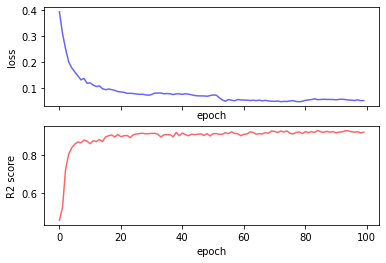

In [26]:
import matplotlib.pyplot as plt

#print(len(losses))
fig, ax = plt.subplots(2, sharex='col', sharey='row')
x = range(num_epochs)
y_train = losses_train
ax[0].plot(x, y_train, c='b', alpha=0.6, label='loss_train')
ax[0].set(xlabel='epoch', ylabel='loss')

y_test = score_valid
ax[1].plot(x, y_test,c='r', alpha=0.6, label='score_valid')
ax[1].set(xlabel='epoch', ylabel='R2 score')


[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'R2 score')]

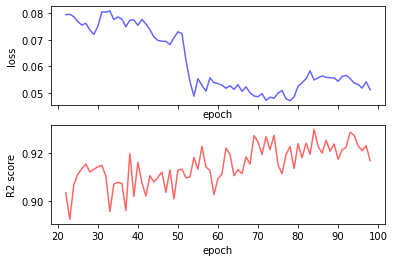

In [32]:
#print(len(losses))
fig, ax = plt.subplots(2, sharex='col', sharey='row')
x = range(num_epochs)
y_train = losses_train
ax[0].plot(x[22:99], y_train[22:99], c='b', alpha=0.6, label='loss_train')
ax[0].set(xlabel='epoch', ylabel='loss')

y_test = score_valid
ax[1].plot(x[22:99], y_test[22:99],c='r', alpha=0.6, label='score_valid')
ax[1].set(xlabel='epoch', ylabel='R2 score')


Model evaluation

In [29]:
#metric = dc.metrics.Metric(dc.metrics.r2_score)
#print(model.evaluate(test_dataset, [metric], transformers))

In [33]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric])
valid_scores = model.evaluate(valid_dataset, [metric])

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)


Evaluating model
Train scores
{'r2_score': 0.9217960797308986}
Validation scores
{'r2_score': 0.9208740690103334}


In [34]:
train_y = train_dataset.y

In [35]:
train_pred= model.predict(train_dataset)

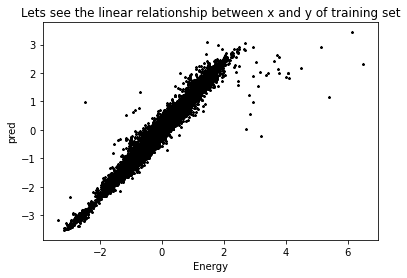

In [36]:
import matplotlib.pyplot as plt
plt.title('Lets see the linear relationship between x and y of training set')
plt.scatter(train_y,train_pred,s=5,c='black',marker='*')
plt.xlabel('Energy')
plt.ylabel('pred')
plt.show()

Import our test data to evaluate model

In [37]:
input_data_test= '../final_data/test1.csv'
tasks=['reaction_energy']
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="reactant_smiles",featurizer=featurizer)
dataset=loader.featurize(input_data_test)


#x = featurizer.featurize(mol_test)
#predicted_energy = model.predict_on_batch(x)
#y_pred = predicted_energy

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


In [38]:
# Normalize them
#transformers1 = [dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset)]
transformers1 = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset, move_mean=True)

In [39]:
dataset = transformers1.transform(dataset)

In [40]:
test_pred= model.predict(dataset)

In [41]:
test_y = dataset.y

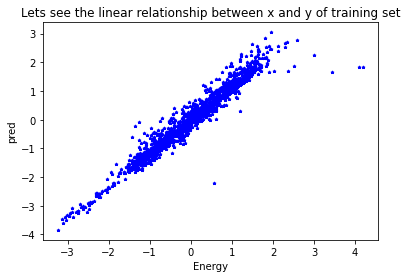

In [42]:
plt.title('Lets see the linear relationship between x and y of training set')
plt.scatter(test_y,test_pred,s=8,c='blue',marker='*')
plt.xlabel('Energy')
plt.ylabel('pred')
plt.show()

Using sklearn to eavluate model

In [43]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt

In [44]:
print("MSE:", mean_squared_error(test_y,test_pred))
print("RMSE:",sqrt(mean_squared_error(test_y,test_pred)))
print("MAE:",mean_absolute_error(test_y,test_pred))
print("R2:", r2_score(test_y,test_pred))

MSE: 0.09054973602983138
RMSE: 0.3009148318541833
MAE: 0.21811019645778879
R2: 0.9094502639701687


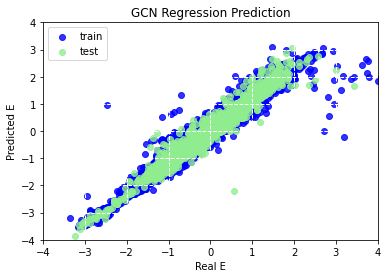

In [45]:
plt.xlim((-4,4))
plt.ylim((-4,4))
plt.title("GCN Regression Prediction")
plt.xlabel("Real E")
plt.ylabel("Predicted E")
plt.grid(color='w', linestyle='--', linewidth=1)
plt.scatter(train_y,train_pred, 
            color="blue", alpha=0.8, label="train")
plt.scatter(test_y,test_pred, 
            color="lightgreen", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()

Chack test2 data

In [46]:
input_data_test2= '../final_data/test2.csv'
tasks=['reaction_energy']
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="reactant_smiles",featurizer=featurizer)
dataset2=loader.featurize(input_data_test2)


/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


In [47]:
# Normalize them
transformers2 = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset2,move_mean=True)

In [48]:
dataset2 = transformers2.transform(dataset2)

In [49]:
test_pred2= model.predict(dataset2)

In [50]:
test2_y = dataset2.y

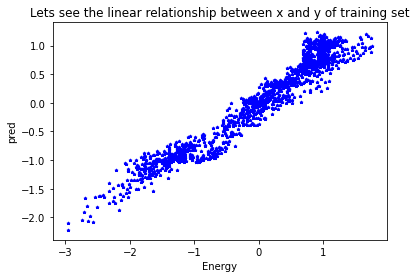

In [51]:
plt.title('Lets see the linear relationship between x and y of training set')
plt.scatter(test2_y,test_pred2,s=8,c='blue',marker='*')
plt.xlabel('Energy')
plt.ylabel('pred')
plt.show()

In [52]:
print("MSE:",mean_squared_error(test2_y,test_pred2))
print("RMSE:",sqrt(mean_squared_error(test2_y,test_pred2)))
print("MAE:",mean_absolute_error(test2_y,test_pred2))
print("R2:",r2_score(test2_y,test_pred2))

MSE: 0.09734733049523073
RMSE: 0.31200533728644886
MAE: 0.2378926425043397
R2: 0.9026526695047693


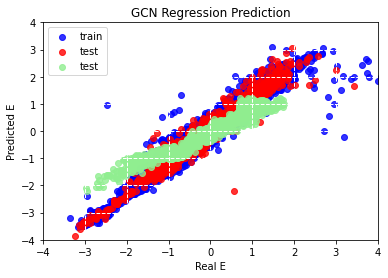

In [53]:
plt.xlim((-4,4))
plt.ylim((-4,4))
plt.title("GCN Regression Prediction")
plt.xlabel("Real E")
plt.ylabel("Predicted E")
plt.grid(color='w', linestyle='--', linewidth=1)
plt.scatter(train_y,train_pred, 
            color="blue", alpha=0.8, label="train")
plt.scatter(test_y,test_pred, 
            color="red", alpha=0.8, label="test")
plt.scatter(test2_y,test_pred2, 
            color="lightgreen", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()

Here is the train evaluation results

In [54]:
print("MSE" , mean_squared_error(train_y,train_pred))
print("RMSE" , sqrt(mean_squared_error(train_y,train_pred)))
print("MAE", mean_absolute_error(train_y,train_pred))
print("R2", r2_score(train_y,train_pred))

MSE 0.07820392026910152
RMSE 0.27964963842118856
MAE 0.20280770578098156
R2 0.9217960797308986


In [ ]:
#hyperparameter
hp = dc.molnet.preset_hyper_parameters
param = hp.hps[ 'graphconvreg' ]
print(param['batch_size'])
g = tf.Graph()
graph_model = dc.nn.SequentialGraph( 75 )
graph_model.add( dc.nn.GraphConv( int(param['n_filters']), 75, activation='relu' ))
graph_model.add( dc.nn.BatchNormalization( epsilon=1e-5, mode=1 ))
graph_model.add( dc.nn.GraphPool() )
graph_model.add( dc.nn.GraphConv( int(param['n_filters']), int(param['n_filters']), activation='relu' ))
graph_model.add( dc.nn.BatchNormalization( epsilon=1e-5, mode=1 ))
graph_model.add( dc.nn.GraphPool() )
graph_model.add( dc.nn.Dense( int(param['n_fully_connected_nodes']), int(param['n_filters']), activation='relu' ))
graph_model.add( dc.nn.BatchNormalization( epsilon=1e-5, mode=1 ))
#graph_model.add( dc.nn.GraphGather(param['batch_size'], activation='tanh'))
graph_model.add( dc.nn.GraphGather( 10 , activation='tanh'))